In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import TwoSlopeNorm
import cmocean as cm

from one_dim_model import *
# one_dim_model is the python script, not the jupyter notebook

In [2]:
# Constants, data, parameters...

rho = 1025 # kg/m^3
c = 4000 # J/(kg C)

z_m = 50.0 # Depth of minimum mixing layer
z_d = 900.0 # Depth for deep ocean restoring term
z_b = 1000.0 # Depth of thermocline

mu = 1/(20 * 365 * 86400) # Deep ocean restoring time scale
gamma = 1/(1.5 * 365 * 86400) # Surface restoring time scale (to be determined through my least squares regression)
kappa = 3e-5

T_0 = 22.0 # Top temperature for initial condition
T_b = 5.0 # Bottom temperature for initial condition (this warms up a bit during runs because of the no-flux at bottom condition)

dt = 10.0 * 86400 # units: s
dz = 5.0 # units: m

z = np.linspace(0.0, z_b, int(z_b / dz) + 1) # Depth at top/bottom of grid cell
z_t = (z[1:] + z[:-1]) / 2 # Depth at the middle of grid cell

In [5]:
T_i = initial_condition(z_t)

In [6]:
# Experimental parameters

years = 50
days = dt / 86400
N = int(years * 360 / days)
t = np.linspace(0.0, years * 360, N + 1)

In [28]:
### Generate parameter space

Qv = np.outer(np.ones(int(years * 360 / days) + 1), np.arange(1.0, 2.0 + 0.01, 0.2))
T0v = np.outer(np.ones(int(years * 360 / days) + 1), np.arange(0.5, 1.0 + 0.01, 0.1))
kappav = np.arange(1e-6, 1e-5 + 1e-7, 1e-6)
gammav = 1 / (np.arange(0.5, 2.9 + 0.2, 0.2) * 365 * 86400)

num_of_expts = Qv.shape[1] * T0v.shape[1] * kappav.shape[0] * gammav.shape[0]
print('Estimated time to run all combinations = {} hours'.format(num_of_expts * 2.5 / (60 * 60)))

Estimated time to run all combinations = 3.25 hours


### Optimise paramaters

Below, we run experiments for all combinations of parameters in the (Qv, T0v, kappav, gammav) space as defined above. We want to pick out the paramaters that gives average temperature and SST responses most closely matching that which we get from ACCESS-OM2. By most closely matching I will mean that the sum of squares of residuals between the 1D model and ACCESS _in both_ the average temperature and SST curves is minimised _simultaneously_. That is, I will then create a cost function (a (|z| - 1) x |Qv| x |T0v| x |kappav| x |gammav| array) containing the sum of squares of residuals between the experimental curves and the 'truth' curve (where the 'truth' is the output from ACCESS-OM2) for each climate variable (e.g., global average temperature anomaly, SST anomaly). We then add the cost function arrays. Finally we find the minimum value in this array. The indices of the minimum in the array will correspond to the indicies in the paramater space that give a least squares best fit for the average temperature and SST responses simultaneously.

We will store the output (a (|z| - 1) x |t| array of temperature profiles over time) from each experiment in a large array, $T$, ie 

$$T = \big(T_{ijkl}(z, t)\big),$$ 

where each $T_{ijkl}(z, t)$ contains one experiment corresponding to some unique combination of the $Q_i, T_{0j}, \kappa_k,$ and $\gamma_l$ paramaters.

Using the experiment array, we can globally average and anomalise with respect to the control simulations for each paramater (only $\gamma$ and $\kappa$ influence the control) to get an array of global average temperature anomalies $$\overline{T}' = \big(\overline{T}'_{ijkl}(t)\big).$$ If we denote the global average temperature anomaly from ACCESS $\overline{T}'_{3D}$, then the we define the cost function (a |Qv| x |T0v| x |kappav| x |gammav| array) 

$$C_1 = (c_{ijkl}),$$ 

where 

$$c_{ijkl} = \sum_{n = 1}^{final} \big(\overline{T}'_{3D}(t_n) - \overline{T}'_{ijkl}(t_n)\big)^2.$$ We then define similarly a cost function, $C_2$, for the SST anomaly.

Then, the optimal paramaters will be chosen to be those that correspond to the indicies of

$$\min_{ijkl} \big(C_1 + C_2\big).$$


### Run the model many times

In [29]:
#%%timeit

GAT = np.empty(shape = (years, Qv.shape[1], T0v.shape[1], kappav.shape[0], gammav.shape[0])) 
SST = np.empty(shape = (years, Qv.shape[1], T0v.shape[1], kappav.shape[0], gammav.shape[0]))

Q_control = np.zeros(int(years * 360 / days) + 1)
T0_control = np.zeros(int(years * 360 / days) + 1)

for k in range(kappav.shape[0]):
    for l in range(gammav.shape[0]):
    
        T_control = model(dt, dz, z_m, z_d, z_b, kappav[k], gammav[l], T_i, Q_control, T0_control, years)
            
        for i in range(Qv.shape[1]):
            for j in range(T0v.shape[1]):

                T_anom = model(dt, dz, z_m, z_d, z_b, kappav[k], gammav[l], T_i, Qv[:, i], T0v[:, j], years) - T_control

                    
                GAT[:, i, j, k, l] = np.array([np.mean(T_anom[:, 36 * n + 1: 36 + 36 * n + 1]) for n in range(50)]) ### find efficient way to loop over the n's
                SST[:, i, j, k, l] = np.array([np.mean(T_anom[0, 36 * n + 1: 36 + 36 * n + 1]) for n in range(50)])

In [50]:
GAT_access = np.array([0.01748657, 0.03167725, 0.03933716, 0.04510498, 0.04980469,
       0.05389404, 0.05749512, 0.06069946, 0.0635376 , 0.06600952,
       0.06838989, 0.07043457, 0.07232666, 0.07421875, 0.07592773,
       0.07763672, 0.07931519, 0.08096313, 0.08267212, 0.08435059,
       0.08578491, 0.08728027, 0.08868408, 0.0897522 , 0.09060669,
       0.09136963, 0.09204102, 0.0925293 , 0.09292603, 0.09350586,
       0.0942688 , 0.09509277, 0.09591675, 0.09655762, 0.09719849,
       0.09750366, 0.09780884, 0.09848022, 0.09909058, 0.099823  ,
       0.10037231, 0.10095215, 0.10137939, 0.10183716, 0.10244751,
       0.10299683, 0.10351562, 0.10388184, 0.10437012, 0.10491943]) # from: RCPwarm_humid_x1_anom_plot[1 : 51]
SST_access = np.array([0.93648349, 1.13570036, 1.16714993, 1.18230086, 1.19178198,
       1.19771543, 1.20203109, 1.20620112, 1.21034915, 1.21344541,
       1.21551125, 1.21773219, 1.21852845, 1.22035654, 1.22081356,
       1.22170856, 1.22232932, 1.2216642 , 1.22123007, 1.22306096,
       1.22410894, 1.22462401, 1.2256159 , 1.22863201, 1.23097451,
       1.23147685, 1.23335583, 1.2354038 , 1.23449599, 1.23381452,
       1.23100409, 1.23111734, 1.23129656, 1.23328307, 1.23548139,
       1.23724301, 1.23511706, 1.2329774 , 1.23172068, 1.232725  ,
       1.23452018, 1.23577964, 1.23538206, 1.23441992, 1.23362529,
       1.23416484, 1.23662231, 1.23647489, 1.23546732, 1.23449098]) # from: RCPwarm_humid_x1_anom_plot[1 : 51]

C1 = np.sum((GAT.transpose() - GAT_access).transpose() ** 2, axis = 0) # Sum of square residuals for GAT
C2 = np.sum((SST.transpose() - SST_access).transpose() ** 2, axis = 0) # Sum of square residuals for SST
C = C1 + C2

optimal_indicies = np.where(C == np.nanmin(C)) # Least squares for GAT and SST simultaneously
GAT_optimal = GAT[:, optimal_indicies[0][0], optimal_indicies[1][0], optimal_indicies[2][0], optimal_indicies[3][0]]
SST_optimal = SST[:, optimal_indicies[0][0], optimal_indicies[1][0], optimal_indicies[2][0], optimal_indicies[3][0]]

print('The optimal $Q$ = {} W/m^2'.format(Qv[0, optimal_indicies[0][0]]))
print('The optimal $T_0$ = {} K'.format(T0v[0, optimal_indicies[1][0]]))
print('The optimal $\kappa$ = {} m/s^2'.format(kappav[optimal_indicies[2][0]]))
print('The optimal $\gamma$ = {} yr^-1$'.format(1 / (gammav[optimal_indicies[3][0]] * 365 * 86400)))

The optimal $Q$ = 1.9999999999999998 W/m^2
The optimal $T_0$ = 0.9999999999999999 K
The optimal $\kappa$ = 1e-06 m/s^2
The optimal $\gamma$ = 0.6999999999999997 yr^-1$


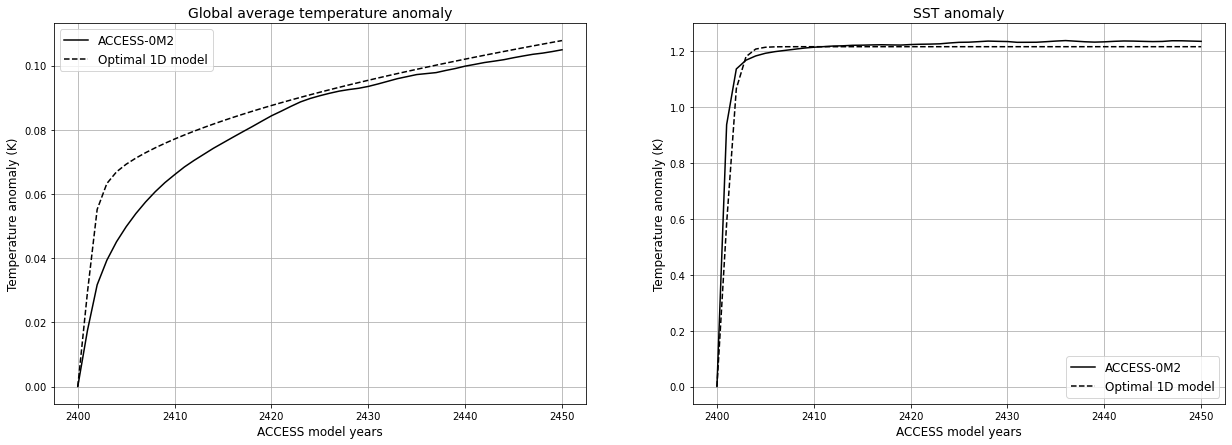

In [51]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(21,7))
t = np.linspace(2400, 2450, 51)

GAT_access_plot = np.append(0, GAT_access)
GAT_optimal_plot = np.append(0, GAT_optimal)
axs[0].plot(t, GAT_access_plot, color = 'k', label = 'ACCESS-0M2')
axs[0].plot(t, GAT_optimal_plot, color = 'k', linestyle = '--', label = 'Optimal 1D model')
axs[0].set_title('Global average temperature anomaly', fontsize=14)
axs[0].set_ylabel('Temperature anomaly (K)', fontsize=12)
axs[0].set_xlabel('ACCESS model years', fontsize=12)
axs[0].legend(fontsize=12)
axs[0].grid()

SST_access_plot = np.append(0, SST_access)
SST_optimal_plot = np.append(0, SST_optimal)
axs[1].plot(t, SST_access_plot, color = 'k', label = 'ACCESS-0M2')
axs[1].plot(t, SST_optimal_plot, color = 'k', linestyle = '--', label = 'Optimal 1D model')
axs[1].set_title('SST anomaly', fontsize=14)
axs[1].set_ylabel('Temperature anomaly (K)', fontsize=12)
axs[1].set_xlabel('ACCESS model years', fontsize=12)
axs[1].legend(fontsize=12)
axs[1].grid()

In [143]:
# Run model using optimal paramaters

years = 50

Q = Qv[:, optimal_indicies[0][0]]
T0 = T0v[:, optimal_indicies[1][0]]
kappa = kappav[optimal_indicies[2][0]]
gamma = gammav[optimal_indicies[3][0]]

T_control = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q_control, T0_control, years)
T_warm = model(dt, dz, z_m, z_d, z_b, kappa, gamma, T_i, Q, T0, years)
T_warmx2 = model(dt, dz, 0.9 * z_m, z_d, z_b, kappa, 0.9 * gamma, T_i, 2 * Q, 2.0 * T0, years) # mixed layer shoals by 90% and gamma is proportional to z_m (gamma = rho * c * z_m * lambda where labda is climate feedback paramater) 
T_cool = model(dt, dz, 1.05 * z_m, z_d, z_b, kappa, 1.05 * gamma, T_i, - Q, - T0, years)
T_coolx2 = model(dt, dz, 1.1 * z_m, z_d, z_b, kappa, 1.1 * gamma, T_i, - 2 * Q, - 2.0 * T0, years)

In [144]:
GAT_control = np.array([np.mean(T_control[:, 36 * n + 1 : 36 + 36 * n + 1]) for n in range(50)])
GAT_warm = np.array([np.mean(T_warm[:, 36 * n + 1 : 36 + 36 * n + 1]) for n in range(50)])
GAT_warmx2 = np.array([np.mean(T_warmx2[:, 36 * n + 1 : 36 + 36 * n + 1]) for n in range(50)])
GAT_cool = np.array([np.mean(T_cool[:, 36 * n + 1 : 36 + 36 * n + 1]) for n in range(50)])
GAT_coolx2 = np.array([np.mean(T_coolx2[:, 36 * n + 1 : 36 + 36 * n + 1]) for n in range(50)])

SST_control = np.array([np.mean(T_control[0, 36 * n + 1 : 36 + 36 * n + 1]) for n in range(50)])
SST_warm = np.array([np.mean(T_warm[0, 36 * n + 1 : 36 + 36 * n + 1]) for n in range(50)])
SST_warmx2 = np.array([np.mean(T_warmx2[0, 36 * n + 1 : 36 + 36 * n + 1]) for n in range(50)])
SST_cool = np.array([np.mean(T_cool[0, 36 * n + 1 : 36 + 36 * n + 1]) for n in range(50)])
SST_coolx2 = np.array([np.mean(T_coolx2[0, 36 * n + 1 : 36 + 36 * n + 1]) for n in range(50)])

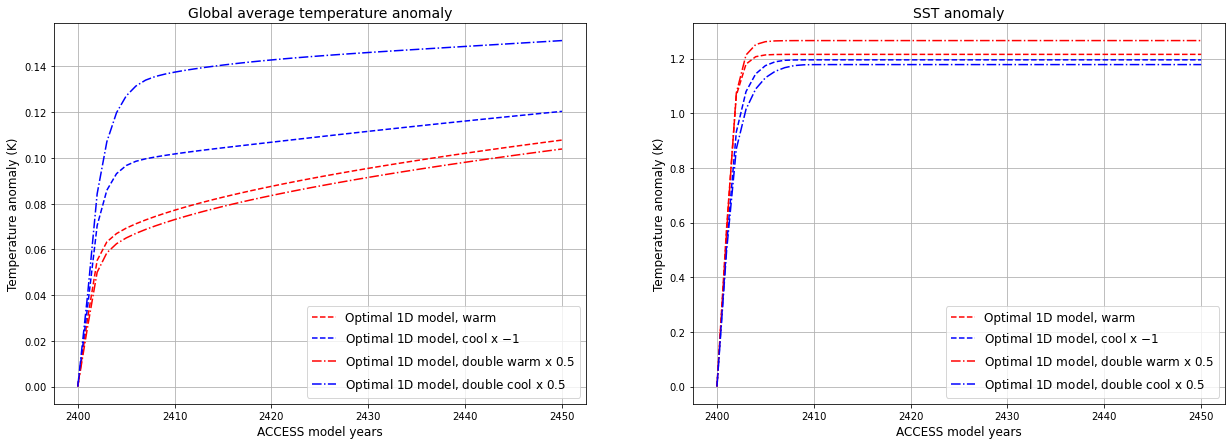

In [147]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(21,7))
t = np.linspace(2400, 2450, 51)

GAT_warm_plot = np.append(0, GAT_warm - GAT_control)
GAT_warmx2_plot = np.append(0, GAT_warmx2 - GAT_control)
GAT_cool_plot = np.append(0, GAT_cool - GAT_control)
GAT_coolx2_plot = np.append(0, GAT_coolx2 - GAT_control)
# axs[0].plot(t, GAT_access_plot, color = 'k', label = 'ACCESS-0M2 warm')
axs[0].plot(t, GAT_warm_plot, color = 'r', linestyle = '--', label = 'Optimal 1D model, warm')
axs[0].plot(t, - 1 * GAT_cool_plot, color = 'b', linestyle = '--', label = 'Optimal 1D model, cool x $-1$')
axs[0].plot(t, 0.5 * GAT_warmx2_plot, color = 'r', linestyle = '-.', label = 'Optimal 1D model, double warm x $0.5$')
axs[0].plot(t, - 0.5 * GAT_coolx2_plot, color = 'b', linestyle = '-.', label = 'Optimal 1D model, double cool x $0.5$')
axs[0].set_title('Global average temperature anomaly', fontsize=14)
axs[0].set_ylabel('Temperature anomaly (K)', fontsize=12)
axs[0].set_xlabel('ACCESS model years', fontsize=12)
axs[0].legend(fontsize=12)
axs[0].grid()

SST_warm_plot = np.append(0, SST_warm - SST_control)
SST_warmx2_plot = np.append(0, SST_warmx2 - SST_control)
SST_cool_plot = np.append(0, SST_cool - SST_control)
SST_coolx2_plot = np.append(0, SST_coolx2 - SST_control)
# axs[1].plot(t, SST_access_plot, color = 'k', label = 'ACCESS-0M2 warm')
axs[1].plot(t, SST_warm_plot, color = 'r', linestyle = '--', label = 'Optimal 1D model, warm')
axs[1].plot(t, - 1 * SST_cool_plot, color = 'b', linestyle = '--', label = 'Optimal 1D model, cool x $-1$')
axs[1].plot(t, 0.5 * SST_warmx2_plot, color = 'r', linestyle = '-.', label = 'Optimal 1D model, double warm x $0.5$')
axs[1].plot(t, - 0.5 * SST_coolx2_plot, color = 'b', linestyle = '-.', label = 'Optimal 1D model, double cool x $0.5$')
axs[1].set_title('SST anomaly', fontsize=14)
axs[1].set_ylabel('Temperature anomaly (K)', fontsize=12)
axs[1].set_xlabel('ACCESS model years', fontsize=12)
axs[1].legend(fontsize=12)
axs[1].grid()

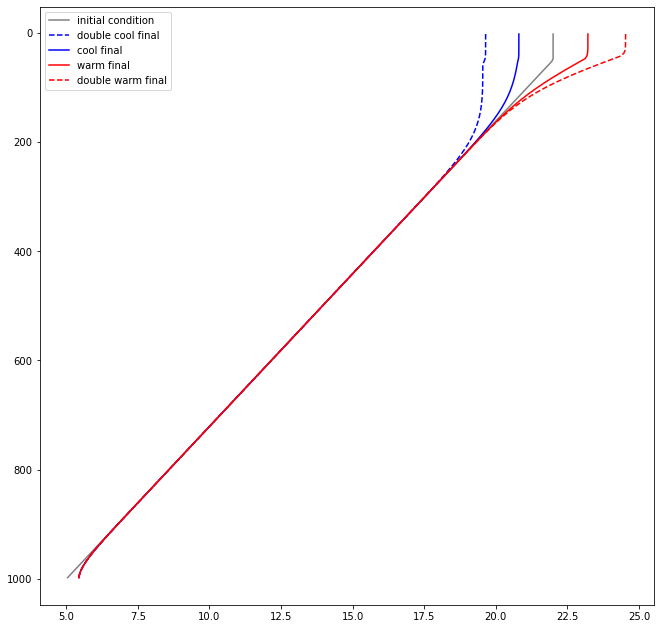

In [146]:
plt.figure(figsize=(11,11))
plt.plot(T_i, z_t, label='initial condition', color = 'gray')
plt.plot(T_coolx2[:, -1], z_t, label='double cool final', color = 'b', linestyle = '--')
plt.plot(T_cool[:, -1], z_t, label='cool final', color = 'b')
plt.plot(T_warm[:, -1], z_t, label='warm final', color = 'r')
plt.plot(T_warmx2[:, -1], z_t, label='double warm final', color = 'r', linestyle = '--')

plt.gca().invert_yaxis()
plt.legend()

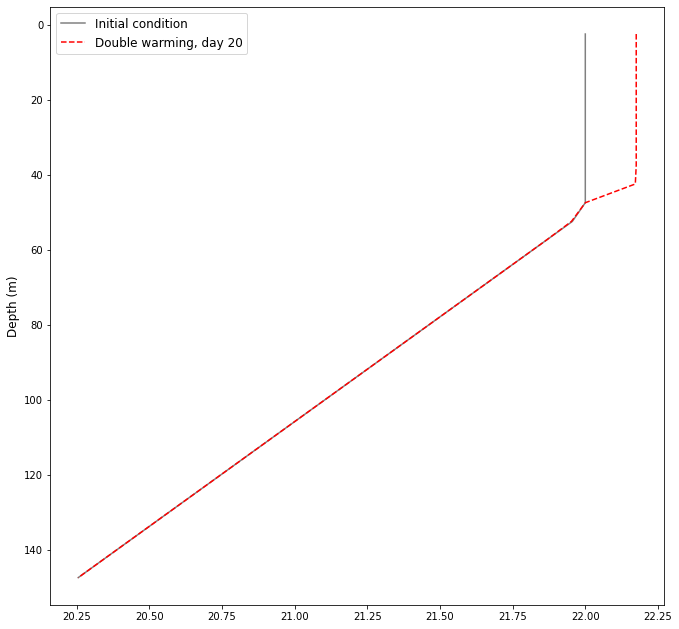

In [161]:
plt.figure(figsize=(11,11))
plt.plot(T_i[:30], z_t[:30], label='Initial condition', color = 'gray')
plt.plot(T_warmx2[:30, 2], z_t[:30], label='Double warming, day 20', color = 'r', linestyle = '--')
#plt.plot(T_warmx2[:, 5], z_t, label='double warm', color = 'r', linestyle = '--')
plt.ylabel('Depth (m)', fontsize=12)
plt.xlabel('Temperature (deg C)', fontsize=12)
plt.title('Illustration of how MLD')

plt.gca().invert_yaxis()
plt.legend(fontsize=12)